In [1]:
import time
import torch
from local_fit import LocalFitter, ExpWin_DS
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import torch.nn as nn
from LFKS import smooth_ecg_KS, smooth_ecg_LFKS, smooth_ecg_KS_2D, smooth_ecg_LFKS_2D
from torch.distributions.normal import Normal
from math import log10



Running on the CPU


# "ECG" Signal
A ECG signal consists of 7 segments inside a cylce:
1. P wave (round)
2. PR segement
3. QRS complex:
    - negative Q wave
    - positive R wave
    - negative S wave
4. ST segement
5. T wave (round)

## Generate ECG

In [64]:
# set noise level
idx_r = 3

# paths
ppath = 'Sim_ecg/' # parent path
traj_path = ppath + 'traj/' # traj path

# noise level
rg_prec_r_dB = [-10.0, -3.0, 0.0, 3.0, 10.0, 20.0, 30.0]

# optimal window parameter for different r
# gamma_optm = [0.93, 0.85, 0.7, 0.67, 0.45, 0.2, 0.1]
gamma_optm = [0.96, 0.85, 0.7, 0.67, 0.8, 0.2, 0.1]

# gamma = gamma_optm[idx_r]

idx_traj = 0
prec_r_dB = rg_prec_r_dB[idx_r]
r = pow(10.0, -prec_r_dB/20)

y_ecg = torch.load(traj_path+'ECG_gt.pt')
T_ecg = y_ecg.size()[0]

err = torch.normal(mean=torch.zeros([T_ecg]), std=r*torch.ones([T_ecg]))
y_ecg_noisy = y_ecg + err

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


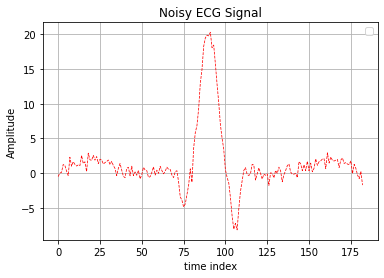

In [65]:
plt.title('Noisy ECG Signal')
plt.xlabel('time index')
plt.ylabel('Amplitude')
plt.plot(torch.arange(0, T_ecg), y_ecg_noisy.squeeze(), '--', color='red',  linewidth=0.75)
plt.legend()
plt.grid()

# plt.savefig('test_local/ecg/dummy_ecg.pdf')
plt.show()

# Local Fit

In [66]:
A = torch.tensor([[1.0, 1.0],
                  [0.0, 1.0]])
C = torch.tensor([1.0, 0.0]).unsqueeze(0)

split_linear_model = LocalFitter(A, C, ExpWin_DS(), A, C)

pm_conti_y = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
])

split_linear_model.fit(y_ecg_noisy.unsqueeze(0), 
                       win_param_fwd=gamma_optm[idx_r], 
                       win_param_bwd=gamma_optm[idx_r], 
                       post_mult=pm_conti_y)             

y_ecg_LF = split_linear_model.generate_signal()

# 1D Implementations
local fit -> surrg for state evolution

In [67]:
y_ecg_LF_KS = smooth_ecg_KS(y_ecg_noisy, 
                    itr_r=60,   itr_q=80, 
                    r_init=1.0, q_init=1.0, 
                    win_q=2, forget_q=0.0)

In [68]:

gamma_1D = gamma_optm[idx_r]
y_ecg_KS = smooth_ecg_LFKS(y_ecg_noisy, gamma=gamma_1D,  
                    itr_r=60,   itr_q=80, 
                    r_init=1.0, q_init=1.0, 
                    win_q=2, forget_q=0.0)

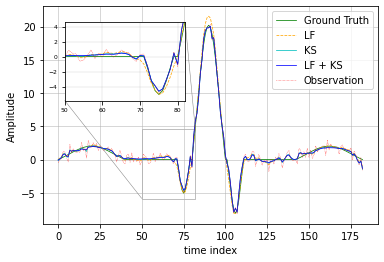

In [69]:
NORMAL_TICK = 10
SMALL_TICK = 6
fig, axmain = plt.subplots()
axins = inset_axes(axmain, width="40%", height="40%", bbox_to_anchor=(.05, .05, .9, .9), bbox_transform=axmain.transAxes, loc=2)

for ax in [axmain, axins]:
    ax.plot(torch.arange(0, T_ecg), y_ecg.squeeze(), color='green',  linewidth=0.75, label='Ground Truth')
    ax.plot(torch.arange(0, T_ecg), y_ecg_LF.squeeze(), '--', color='orange', linewidth=0.75, label='LF')
    ax.plot(torch.arange(0, T_ecg), y_ecg_KS.squeeze(), color='c', linewidth=0.75, label='KS')
    ax.plot(torch.arange(0, T_ecg), y_ecg_LF_KS.squeeze(), color='blue', linewidth=0.75, label='LF + KS')
    ax.plot(torch.arange(0, T_ecg), y_ecg_noisy.squeeze(), ':', color='red',  linewidth=0.5, label='Observation')

# layout main axes
axmain.set_xlabel('time index')
axmain.set_ylabel('Amplitude')
axmain.tick_params(axis='x', labelsize=NORMAL_TICK)
axmain.tick_params(axis='y', labelsize=NORMAL_TICK)    
axmain.grid(linewidth=0.5)
axmain.legend(loc='upper right')

# layout zoomed axes
axins.tick_params(axis='x', labelsize=SMALL_TICK)
axins.tick_params(axis='y', labelsize=SMALL_TICK)
axins.grid(linewidth=0.25)
x_min, x_max = 50, 82
y_min, y_max = min(y_ecg_noisy.squeeze()[x_min:x_max])-1.0, max(y_ecg_noisy.squeeze()[x_min:x_max])+1.0 
axins.set_xlim(x_min, x_max) 
axins.set_ylim(y_min, y_max) 

mark_inset(axmain, axins, loc1=1, loc2=3, fc="none", ec="0.5", lw=0.5)

plt.savefig('test_local/ecg_1D/ecg_r2_%i_dB.pdf'%(-prec_r_dB))
plt.show()
plt.close()

In [70]:
loss_func = nn.MSELoss(reduction='mean')
MSE_LF = loss_func(y_ecg, y_ecg_LF.squeeze())
MSE_LF = 10*torch.log10(MSE_LF)

MSE_KS = loss_func(y_ecg, y_ecg_KS.squeeze())
MSE_KS = 10*torch.log10(MSE_KS)


# effective window length
L_eff_left = round(-1/log10(gamma_1D))
L_eff_right = round(-1/log10(gamma_1D))
t_range = range(L_eff_left, T_ecg - L_eff_right) 
MSE_LF_KS = loss_func(y_ecg, y_ecg_LF_KS.squeeze())
MSE_LF_KS = 10*torch.log10(MSE_LF_KS)


print('Noise Floor: ', -prec_r_dB, '[dB]')
print('MSE - LF on ECG: ', MSE_LF, '[dB]')
print('MSE - KS on ECG: ', MSE_KS, '[dB]')
print('MSE - LF and KS on ECG: ', MSE_LF_KS, '[dB]')


Noise Floor:  -3.0 [dB]
MSE - LF on ECG:  tensor(-6.1587) [dB]
MSE - KS on ECG:  tensor(-8.0224) [dB]
MSE - LF and KS on ECG:  tensor(-8.3903) [dB]


# 2D Implementaitons
local fit -> part of state vector


In [71]:
# init var
r0 = 1.0
q0 = 1.0
R_init = r0*r0*torch.eye(1).unsqueeze(2).repeat(1, 1, T_ecg)
Q_init = q0*q0*torch.tensor([[1/3, 1/2], [1/2, 1.0]]).unsqueeze(2).repeat(1, 1, T_ecg)

y_ecg_KS_2D = smooth_ecg_KS_2D(y_ecg_noisy, R_init, Q_init)
y_ecg_KS_2D = y_ecg_KS_2D[0, :]

In [72]:
gamma_2D = gamma_optm[idx_r]
y_ecg_LFKS_2D = smooth_ecg_LFKS_2D(y_ecg_noisy, gamma=gamma_2D)
y_ecg_LFKS_2D = y_ecg_LFKS_2D[0, :]

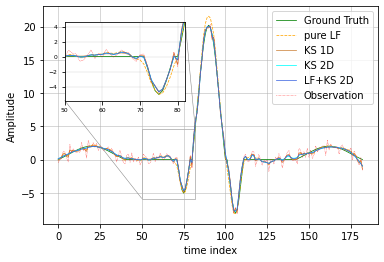

In [73]:
NORMAL_TICK = 10
SMALL_TICK = 6
fig, axmain = plt.subplots()
axins = inset_axes(axmain, width="40%", height="40%", bbox_to_anchor=(.05, .05, .9, .9), bbox_transform=axmain.transAxes, loc=2)

for ax in [axmain, axins]:
    ax.plot(torch.arange(0, T_ecg), y_ecg.squeeze(), color='green',  linewidth=0.75, label='Ground Truth')
    ax.plot(torch.arange(0, T_ecg), y_ecg_LF.squeeze(), '--', color='orange', linewidth=0.75, label='pure LF')
    ax.plot(torch.arange(0, T_ecg), y_ecg_KS.squeeze(), color='peru', linewidth=0.75, label='KS 1D')
    ax.plot(torch.arange(0, T_ecg), y_ecg_KS_2D.squeeze(), color='cyan', linewidth=0.75, label='KS 2D')
    ax.plot(torch.arange(0, T_ecg), y_ecg_LFKS_2D.squeeze(), color='royalblue', linewidth=0.75, label='LF+KS 2D')
    ax.plot(torch.arange(0, T_ecg), y_ecg_noisy.squeeze(), ':', color='red',  linewidth=0.5, label='Observation')

# layout main axes
axmain.set_xlabel('time index')
axmain.set_ylabel('Amplitude')
axmain.tick_params(axis='x', labelsize=NORMAL_TICK)
axmain.tick_params(axis='y', labelsize=NORMAL_TICK)    
axmain.grid(linewidth=0.5)
axmain.legend(loc='upper right')

# layout zoomed axes
axins.tick_params(axis='x', labelsize=SMALL_TICK)
axins.tick_params(axis='y', labelsize=SMALL_TICK)
axins.grid(linewidth=0.25)
x_min, x_max = 50, 82
y_min, y_max = min(y_ecg_noisy.squeeze()[x_min:x_max])-1.0, max(y_ecg_noisy.squeeze()[x_min:x_max])+1.0 
axins.set_xlim(x_min, x_max) 
axins.set_ylim(y_min, y_max) 

mark_inset(axmain, axins, loc1=1, loc2=3, fc="none", ec="0.5", lw=0.5)


plt.savefig('test_local/ecg_2D/ecg_r2_%i_dB.pdf'%(-prec_r_dB))
plt.show()
plt.close()

In [74]:

loss_func = nn.MSELoss(reduction='mean')
MSE_LF = loss_func(y_ecg, y_ecg_LF.squeeze())
MSE_LF = 10*torch.log10(MSE_LF)

MSE_KS = loss_func(y_ecg, y_ecg_KS.squeeze())
MSE_KS = 10*torch.log10(MSE_KS)

MSE_KS_2D = loss_func(y_ecg, y_ecg_KS_2D.squeeze())
MSE_KS_2D = 10*torch.log10(MSE_KS_2D)

# effective window length
L_eff_left = round(-1/log10(gamma_2D))
L_eff_right = round(-1/log10(gamma_2D))
t_range = range(L_eff_left, T_ecg - L_eff_right) 
MSE_LFKS_2D = loss_func(y_ecg[t_range], y_ecg_LFKS_2D.squeeze()[t_range])
MSE_LFKS_2D = 10*torch.log10(MSE_LFKS_2D)


print('Noise Floor: ', -prec_r_dB, '[dB]')
print('MSE - LF: ', MSE_LF, '[dB]')
print('MSE - KS: ', MSE_KS, '[dB]')
print('MSE - KS_2D: ', MSE_KS_2D, '[dB]')
print('MSE - LFKS_2D: ', MSE_LFKS_2D, '[dB]')

Noise Floor:  -3.0 [dB]
MSE - LF:  tensor(-6.1587) [dB]
MSE - KS:  tensor(-8.0224) [dB]
MSE - KS_2D:  tensor(-10.1916) [dB]
MSE - LFKS_2D:  tensor(-10.1143) [dB]
